In [2]:
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import json
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
ticker = 'CVX'
start_date = '2000-01-01'
end_date = '2024-01-01'
data = yf.download(ticker, start=start_date, end=end_date)
data = data['Close']
data = data['CVX']
print(data.head())

[*********************100%***********************]  1 of 1 completed

Date
2000-01-03    41.81250
2000-01-04    41.81250
2000-01-05    42.56250
2000-01-06    44.37500
2000-01-07    45.15625
Name: CVX, dtype: float64


In [4]:
train_end_year = 2018
validation_end_year = 2022

In [5]:
train = data[data.index.year <= train_end_year]
validation = data[(data.index.year > train_end_year) & (data.index.year <= validation_end_year)]
test = data[data.index.year > validation_end_year]

train_list = train.to_list()
validation_list = validation.to_list()
test_list = test.to_list()

print(train_list[:5], len(train_list))
print(validation_list[:5], len(validation_list))
print(test_list[:5], len(test_list))

[41.8125, 41.8125, 42.5625, 44.375, 45.15625] 4779
[110.69000244140625, 108.56999969482422, 110.81999969482422, 112.26000213623047, 111.7699966430664] 1008
[173.99000549316406, 172.13999938964844, 175.24000549316406, 176.55999755859375, 175.17999267578125] 250


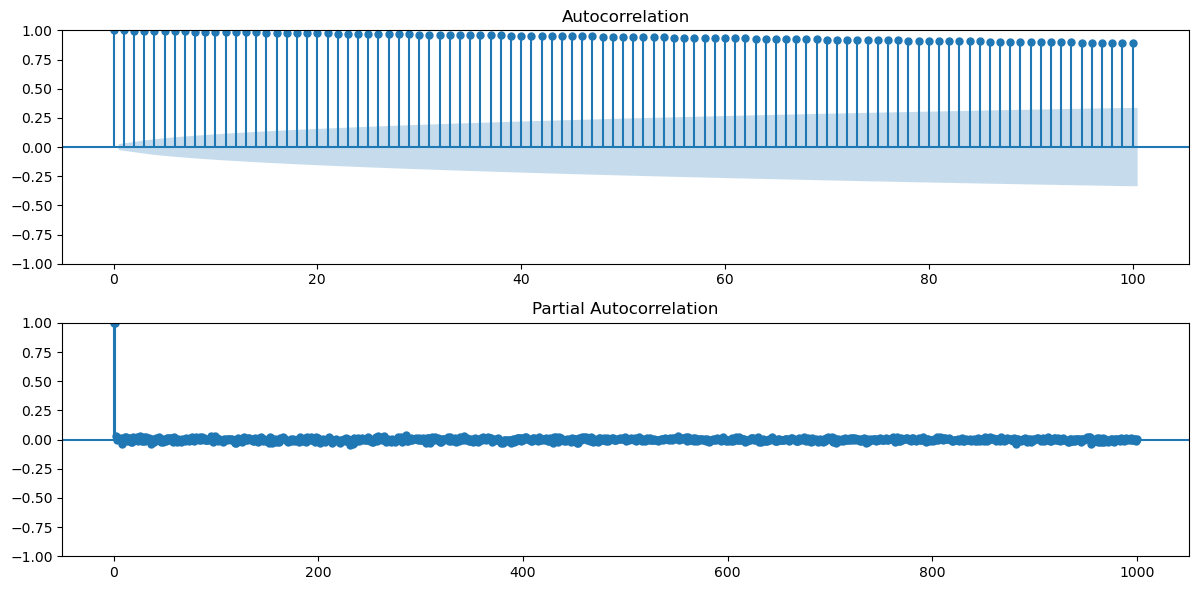

In [27]:
# Plot Autocorrelation
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)  # First subplot
plot_acf(data, ax=plt.gca(), lags=100)
plt.title("Autocorrelation")

# Plot Partial Autocorrelation
plt.subplot(2, 1, 2)  # Second subplot
plot_pacf(data, ax=plt.gca(), lags=1000, method='ywm')
plt.title("Partial Autocorrelation")

plt.tight_layout()
plt.show()

In [40]:
def show_parameters(preds, ground_truth):
    test_mape = np.mean(np.abs((preds - ground_truth) / ground_truth)) * 100
    test_rmse = np.sqrt(np.average(np.square(preds - ground_truth)))
    print(f"test_mape: {test_mape}")
    print(f"test_rmse: {test_rmse}")
    
    # Validation Data
    plt.plot(ground_truth, label='Actual Data')
    plt.plot(ground_truth.index, preds, label='ARIMA Predictions')

    plt.title('Arima Prediction')
    plt.xlabel('Time Steps')
    plt.ylabel('Values')


    plt.tight_layout()
    plt.show()

In [31]:
# regular implementation
order = (2, 1, 2)
# validation
model = ARIMA(train_list + validation_list, order=order)
model_fit = model.fit()
preds = []
results = model_fit.forecast()

seen = train_list + validation_list
for _ in tqdm(range(len(test_list))):
    model = ARIMA(seen + preds, order=order)
    model_fit = model.fit()
    result = model_fit.forecast()
    preds.append(result[0])


100%|██████████| 250/250 [04:04<00:00,  1.02it/s]


test_mape: 12.499810065093218
test_rmse: 21.467526668822394


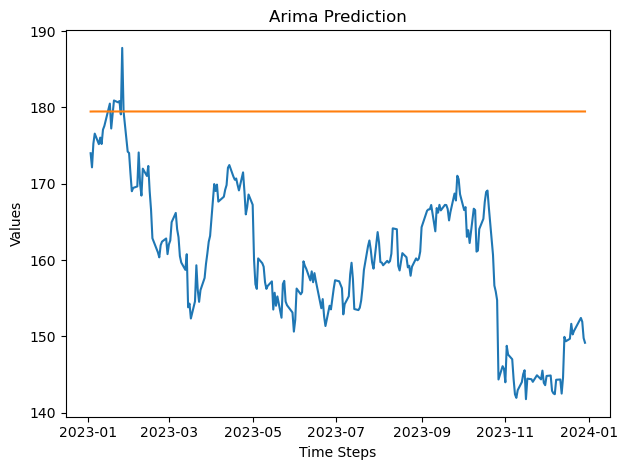

In [41]:
show_parameters(preds, test)

In [ ]:
# walk forward implementation
history = train_list
wf_val_mean = []
wf_val_cfd = []


for t in tqdm(range(len(validation_list))):
    model = ARIMA(history, order=order)
    model_fit = model.fit()
    next_day = model_fit.get_forecast(steps=1) 
    wf_val_mean.append(next_day.predicted_mean)
    wf_val_cfd.append(next_day.conf_int())
    history.append(validation.iloc[t])

wf_val_mean = np.concatenate(wf_val_mean)
wf_val_cfd = np.concatenate(wf_val_cfd)

results = model_fit.get_forecast(steps=len(test_list))
wf_test_mean = results.predicted_mean
wf_test_cfd = results.conf_int()

100%|██████████| 1008/1008 [22:27<00:00,  1.34s/it]


[[106.49476323 111.38275024]
 [108.12067886 113.01324556]
 [106.25708799 111.14647257]
 ...
 [176.59179865 182.60382617]
 [174.1117121  180.12473284]
 [175.24139332 181.25421605]]
val_mape: 1.530237257612286
test_mape: 11.792845582447859


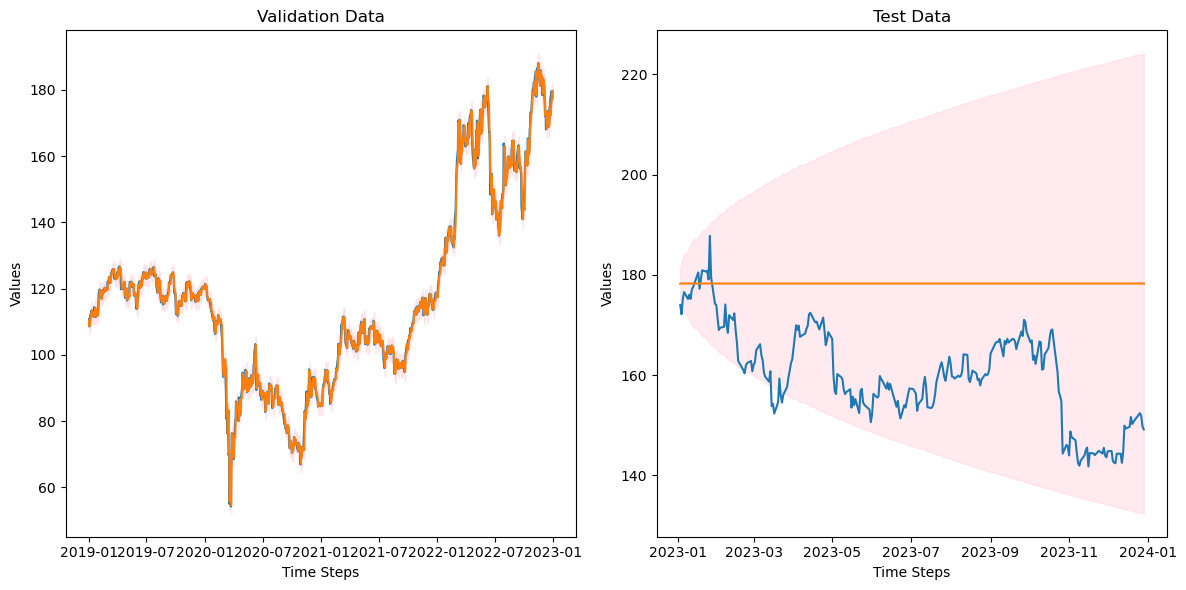

In [ ]:
show_parameters(wf_val_mean, wf_val_cfd, wf_test_mean, wf_test_cfd)

In [6]:
result = adfuller(data.to_list())
output = {
    "Test Statistic": result[0],
    "p-value": result[1],
    "Lags Used": result[2],
    "Number of Observations Used": result[3],
    "Critical Values": result[4],
    "Stationary?": "Yes" if result[1] < 0.05 else "No"
}
print(json.dumps(output, indent=4))

{
    "Test Statistic": -1.2764642211692254,
    "p-value": 0.639870007988992,
    "Lags Used": 26,
    "Number of Observations Used": 6010,
    "Critical Values": {
        "1%": -3.4314385349768357,
        "5%": -2.86202103254593,
        "10%": -2.567026051146038
    },
    "Stationary?": "No"
}
